## Example to load the network, sample 4 levels at random from the latent space and then plot them using matplotlib.


### For Google Colab (I didn't use it)

In [331]:
# from google.colab import drive
# drive.mount('/content/drive')

In [332]:
#!cp 'path/to/file' 'path/to/drive'

### Run it just one time

In [1]:
# import os
# os.chdir("lab6/exercise_DL_pcg")

## Start here

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from numpy import random

from vae_mario import VAEMario
from plotting_utilities import plot_decoded_level

In [7]:
# Loading the model
model_name = "mario_vae_zdim_2_overfitted"
z_dim = 2
vae = VAEMario(z_dim=z_dim)
vae.load_state_dict(torch.load(f"./models/{model_name}.pt"))

VAEMario(
  (encoder): Sequential(
    (0): Linear(in_features=2156, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (fc_var): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2156, bias=True)
  )
)


<All keys matched successfully>

# Latent Variable Evolution Lab


## Sample from the VAE and then implement some search algorithm of choise to search the latent space for a particular level (e.g. one with many ground tiles)

In [32]:
# Sampling random zs
target_zs = 2.5 * torch.randn((4, z_dim))
levels = vae.decode(target_zs)
level_1 = levels[0]
target = torch.argmax(level_1, dim=0)
target

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

I define some functions to improve my z

In [33]:
def find_best_z(target, zs):
    levels = vae.decode(zs)
    best_match = 10000
    z = 0
    for idx, level in enumerate(levels):
        output = torch.argmax(level, dim=0)
        # Create a matrix of 0 and 1 to show which parts are different
        compare_tensor = (output == target).int()
        _,count = compare_tensor.unique(return_counts=True)
        wrong_tiles = count[0]
        if wrong_tiles < best_match:
            z = zs[idx]
            best_match = wrong_tiles
            # print("Found better fitting, new wrong tiles: ", best_match.item())
    return z, best_match

def improve_z(target, z, noise):
    zs = [z + noise * torch.randn(z_dim) for _ in range(10000)]
    zs = torch.stack(zs)
    return find_best_z(target, zs)

def decimal_range(start, stop, increment):
    while start > stop:
        yield start
        start += increment


Actual search for best fitting

In [34]:
# Create some z in order to find the best fit for the previous target

zs = [z + 0.1 * torch.randn(z_dim) for z in range(100)]
zs = torch.stack(zs)
# First search on large latent space
z, best = find_best_z(target, zs)
print("Starting wrong tiles: ", best.item())

# Refine search
print("Start refine search")
new_z = z
# Improve z decreasing noise magnitude while I am approaching solution
for noise in decimal_range(0.5, 0, -0.1):
    # print("Noise is: ", noise)
    new_z, new_best = improve_z(target, new_z, noise)
    if new_best == 0:
        break

print("Final wrong tiles:", new_best.item())


Starting wrong tiles:  9
Start refine search
Final wrong tiles: 1


In [35]:
print(f"My guess: {new_z}\nTarget: {target_zs[0]}")
print("The difference between the two is:", new_z - target_zs[0])

My guess: tensor([-0.2255, -1.4772])
Target: tensor([-0.2820, -1.6104])
The difference between the two is: tensor([0.0566, 0.1332])


In [36]:
# Getting levels from them using the decoder
levels = vae.decode(target_zs)
level_imgs = [plot_decoded_level(level) for level in levels]

# Creating new image
out_level = vae.decode(new_z)[0]
out_level_img = plot_decoded_level(out_level)

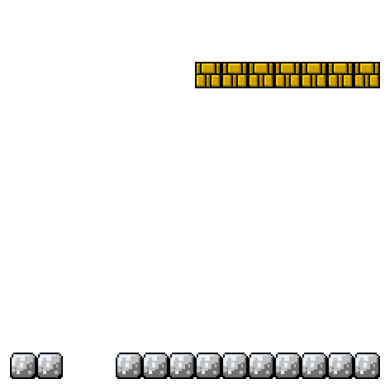

In [37]:
# Plotting Target
plt.imshow(level_imgs[0])
_ = plt.axis("off")


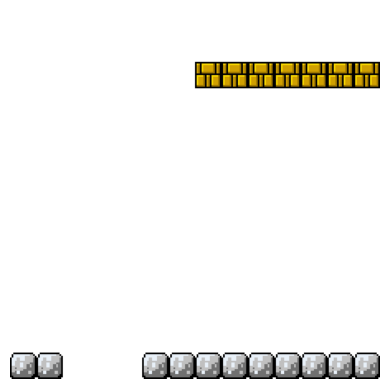

In [38]:
# Plotting reconstructed one
plt.imshow(out_level_img)
_ = plt.axis("off")
